# Applied Deep Learning Assignment Task 1
`Name: Gangula Karthik`<br>
`Admin_no: 223715Y`

---

_**Develop and compare deep learning and transfer learning models for early brain tumor detection and classification to optimize treatment selection and improve patient outcomes.**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

Brain tumors are abnormal growths within or around the brain that can be malignant or benign, requiring accurate and early diagnosis for effective treatment. Distinguishing brain tumors from other cystic or tumor-like growths in MRI scans remains a significant challenge in medical imaging. Advanced deep learning techniques offer the potential to enhance early detection and diagnosis, reducing misclassification and improving patient outcomes. Based on their location and origin, brain tumors can be categorized into types such as Gliomas, which originate in the brain or spinal cord; Meningiomas, arising from the protective membranes (meninges) surrounding the brain and spinal cord; and Pituitary Tumors, which develop in the pituitary gland. Developing deep learning-based models to differentiate between these tumor types and similar-appearing cysts in MRI scans is crucial for guiding timely and appropriate treatment strategies.

---

### Setup

Import all the Python libraries we will need

---

In [48]:
# !pip install tensorflow-addons

In [49]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
from tqdm import tqdm
import phik
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm 

### Loading the datasets

Parsing the folders and putting them in a dataframe.

---

In [50]:
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

In [51]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory): 
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for img_file in os.listdir(label_path):  
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [52]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

'Test DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

### Data Understanding

Analysing the data in depth in order to understand the data and how to apply different transformations. 

---

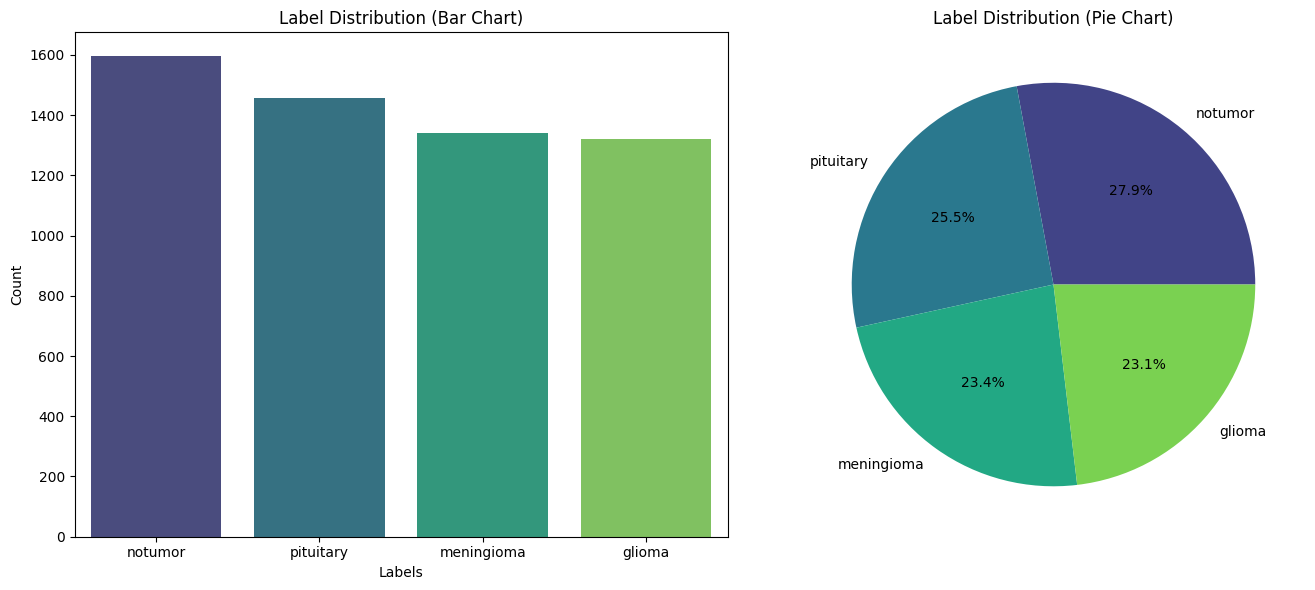

In [53]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [54]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None 

train_df["width"], train_df["height"] = zip(*train_df["file_path"].apply(get_image_size))

train_df["aspect_ratio"] = train_df["width"] / train_df["height"]

train_df[["width", "height", "aspect_ratio"]].describe()

width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


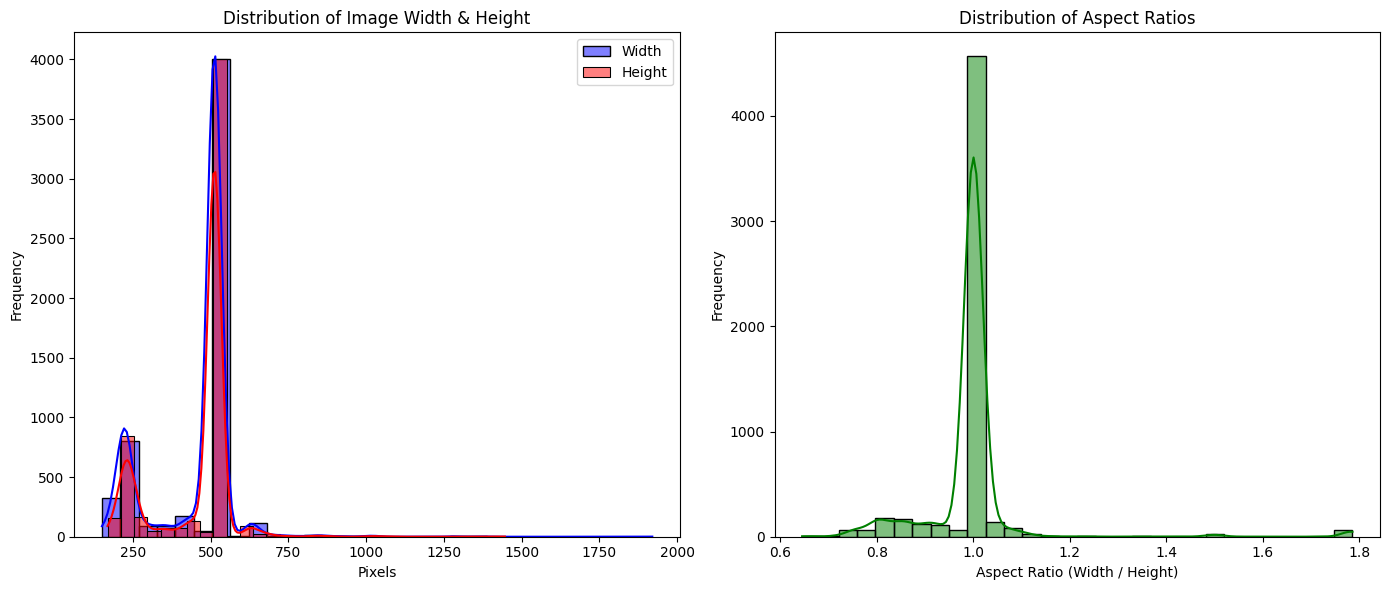

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

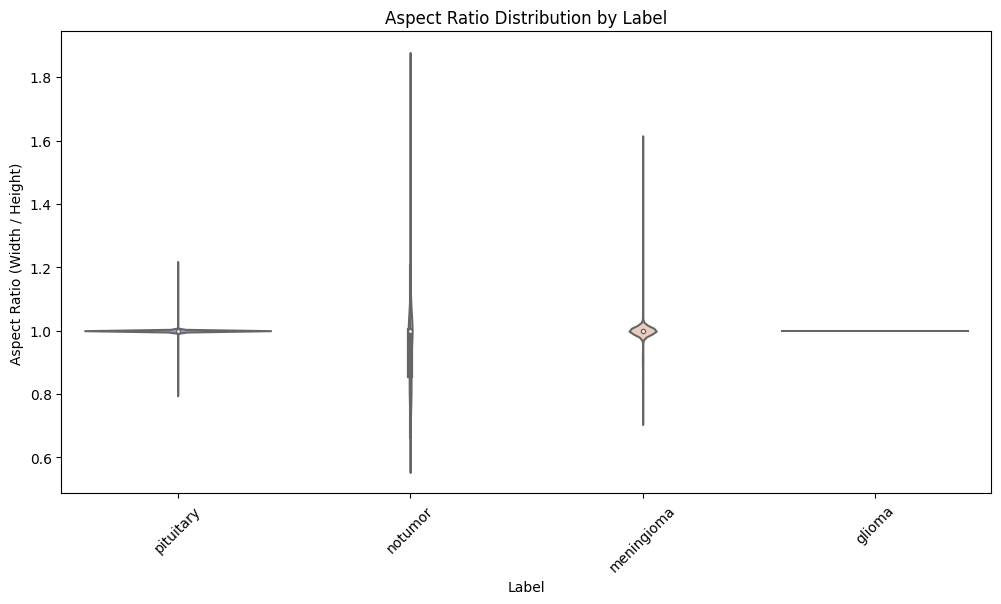

In [56]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

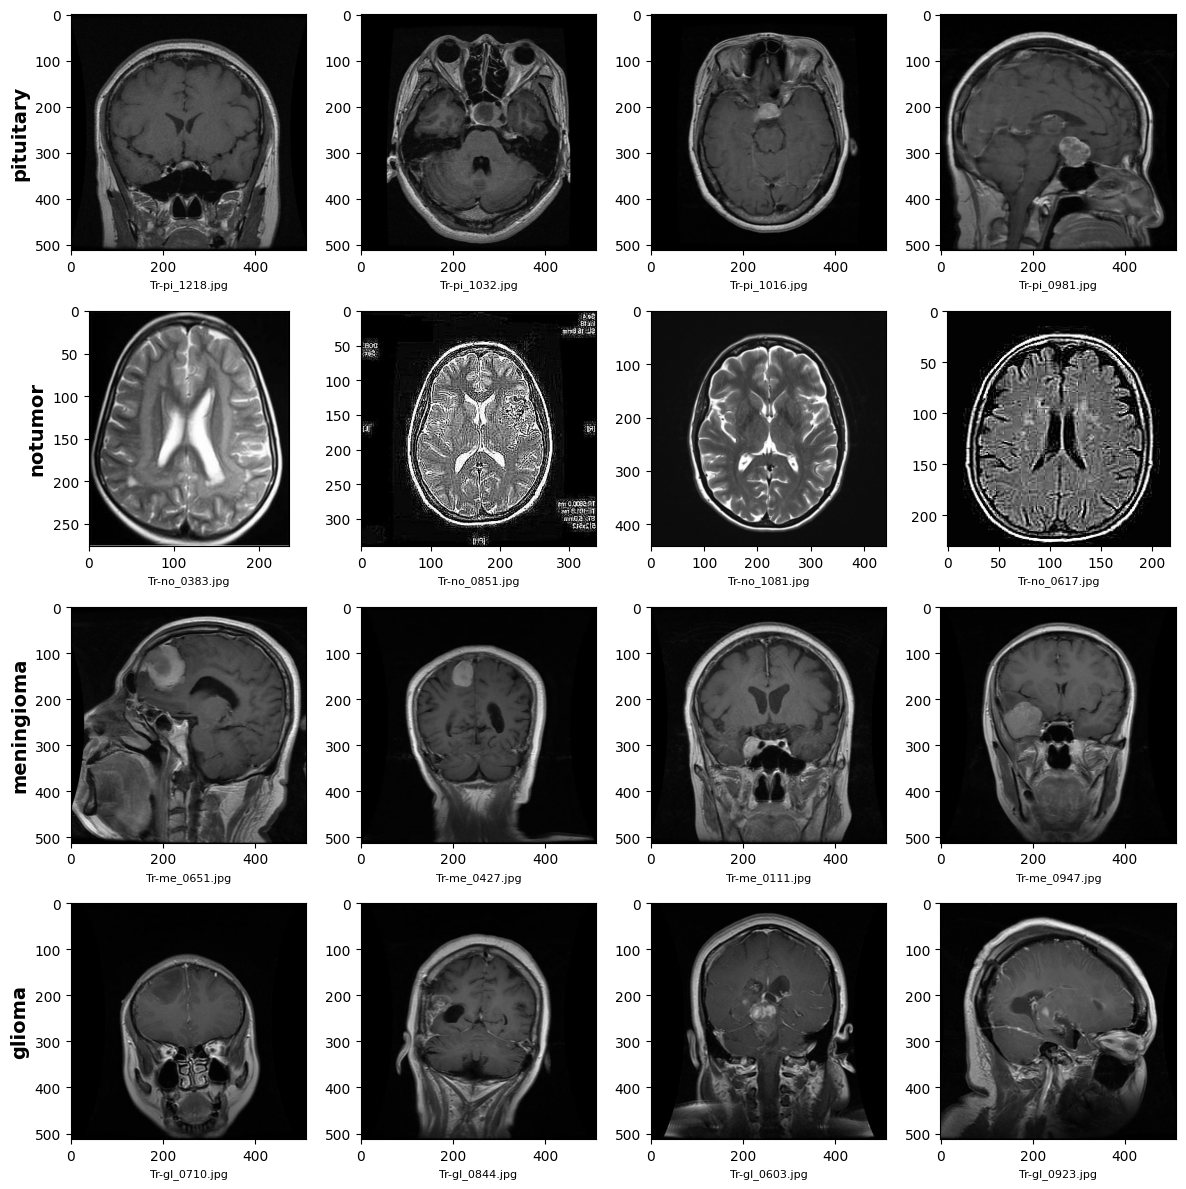

In [57]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)
    
    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = axes[row, col]
        ax.imshow(img)
        
        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold") 
        
        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

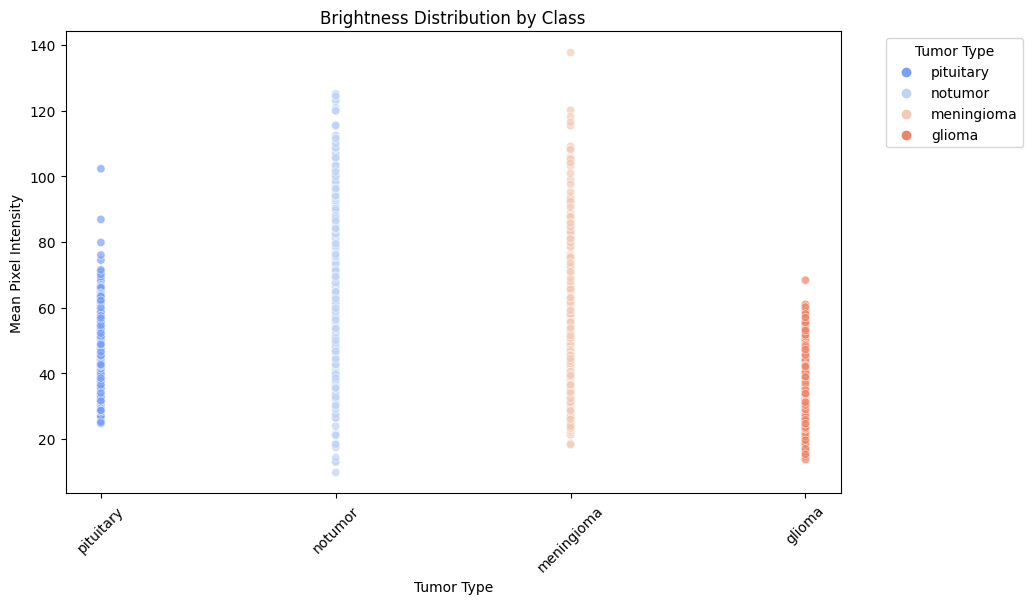

In [58]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["label"], y=train_df["brightness"], alpha=0.7, hue=train_df["label"], palette="coolwarm")
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

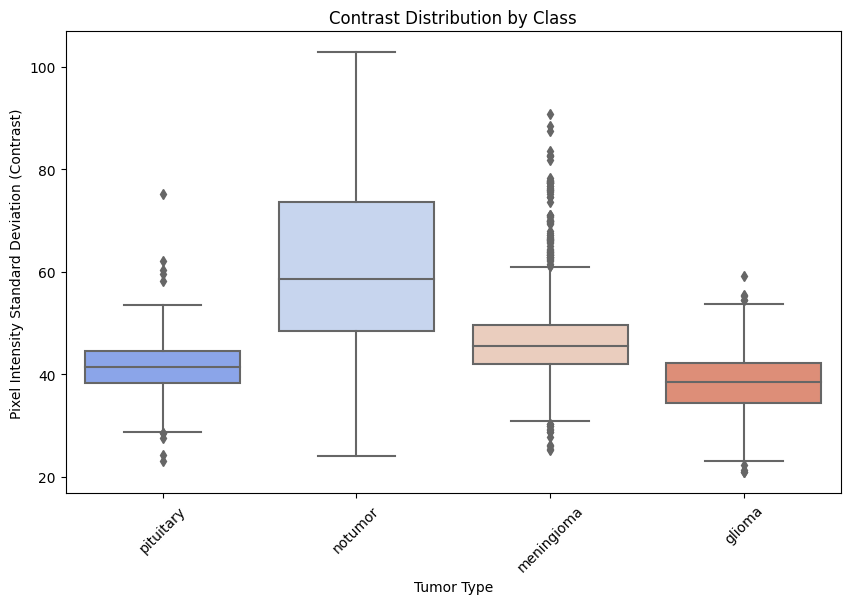

In [59]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

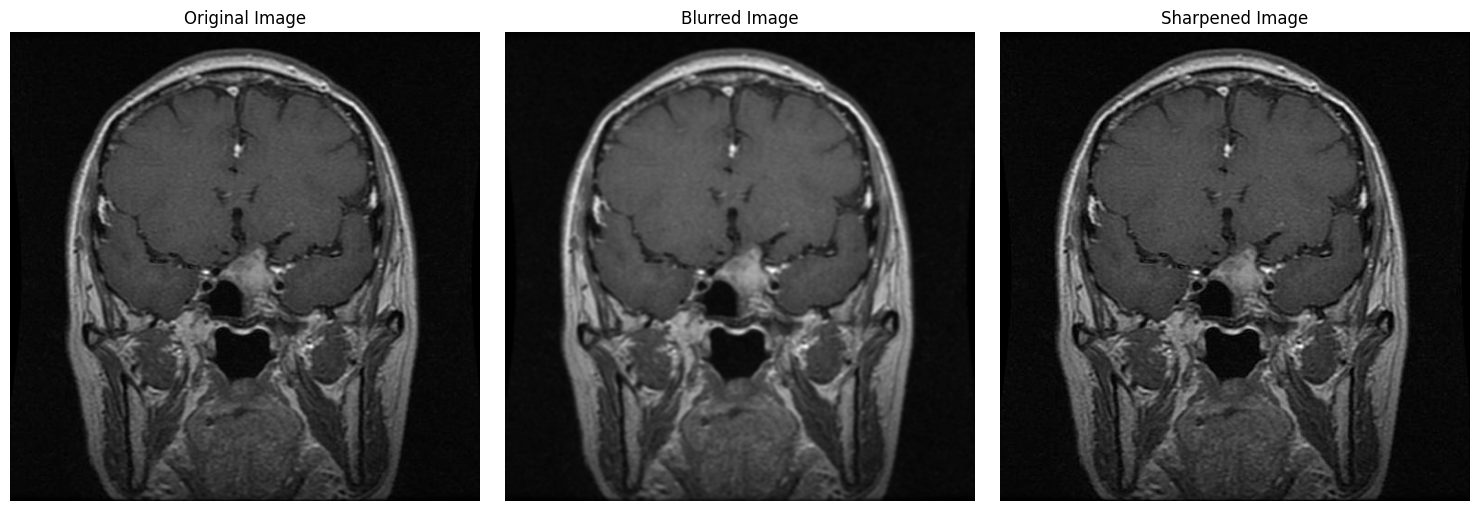

In [60]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

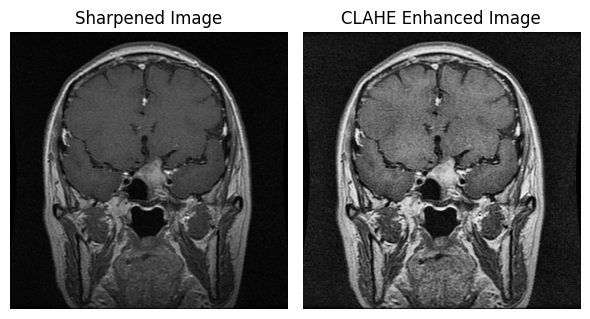

In [61]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

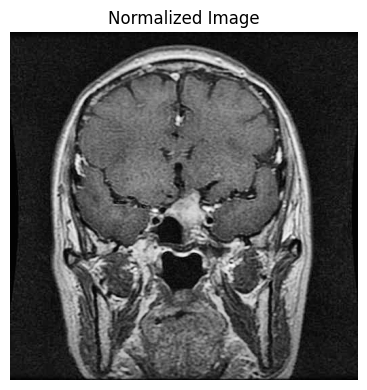

In [62]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

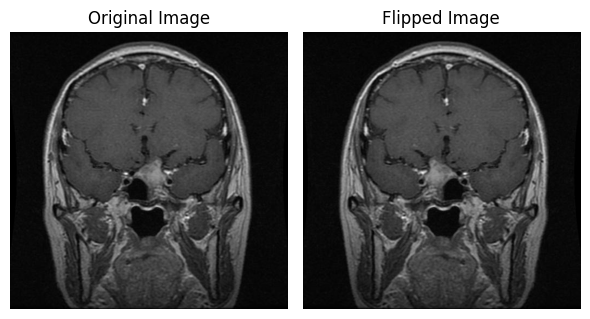

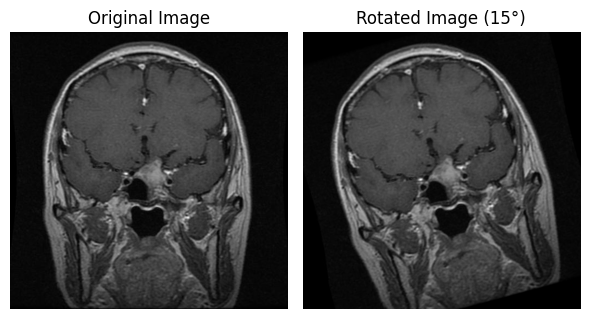

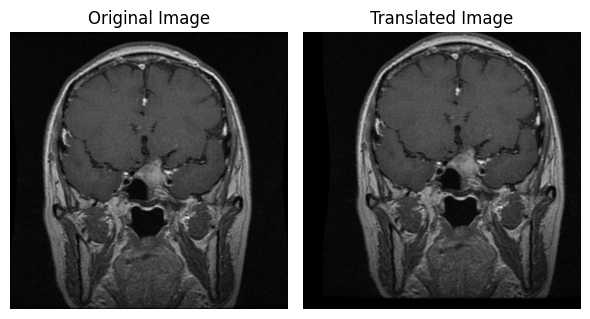

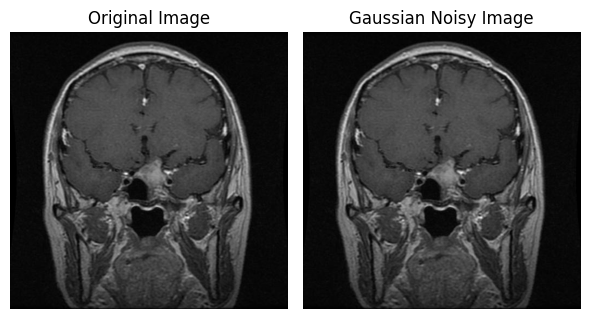

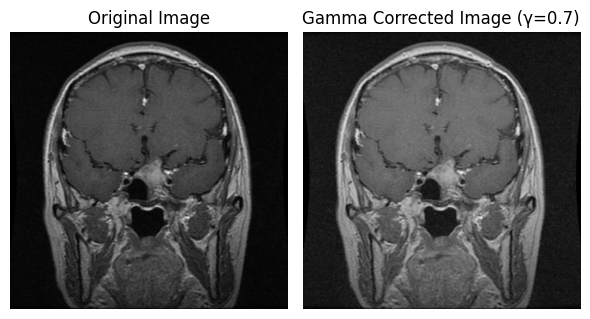

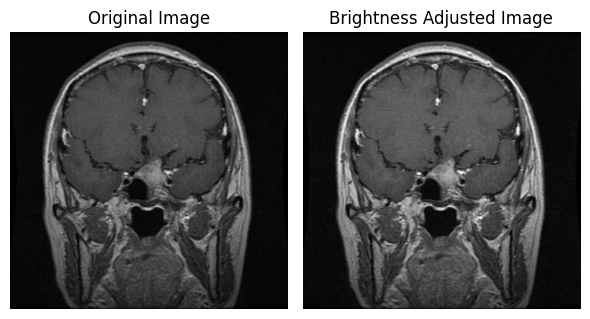

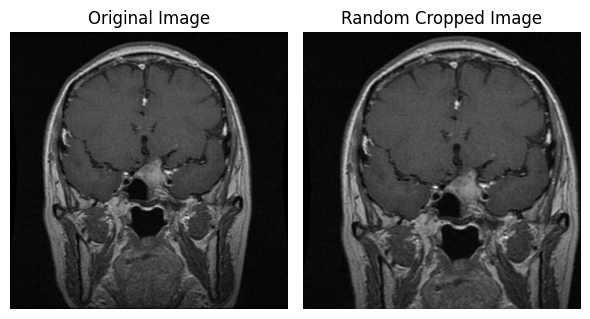

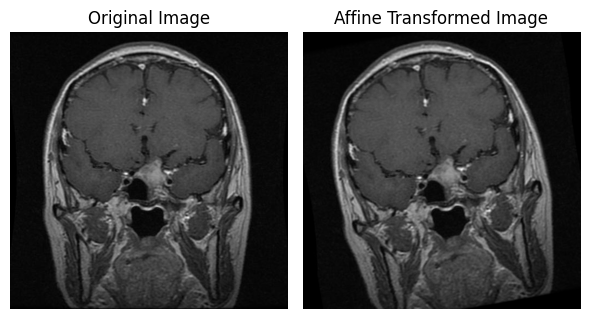

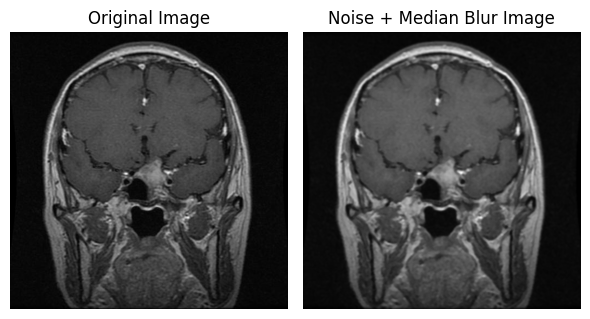

In [63]:
# Load MRI image (replace with your image path)
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_single_transformation(original, transformed, title):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### 1️⃣ Horizontal Flip ###
flipped = cv2.flip(img, 1)  # 1 means horizontal flip
visualize_single_transformation(img, flipped, "Flipped Image")

### 2️⃣ Rotation (±15 degrees) ###
angle = 15  # 15 degrees rotation
(h, w) = img.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
visualize_single_transformation(img, rotated, "Rotated Image (15°)")

### 3️⃣ Translation (10% random shift) ###
tx, ty = np.random.randint(-int(w*0.1), int(w*0.1)), np.random.randint(-int(h*0.1), int(h*0.1))
M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
translated = cv2.warpAffine(img, M_translation, (w, h))
visualize_single_transformation(img, translated, "Translated Image")

### 4️⃣ Gaussian Noise (σ=0.03) ###
noise = np.random.normal(0, 0.05, img.shape).astype(np.uint8)
gaussian_noisy = cv2.add(img, noise)
visualize_single_transformation(img, gaussian_noisy, "Gaussian Noisy Image")

### 5️⃣ Gamma Correction (γ=0.7) ###
gamma_corrected = np.array(255 * (img / 255) ** 0.7, dtype='uint8')
visualize_single_transformation(img, gamma_corrected, "Gamma Corrected Image (γ=0.7)")

### 6️⃣ Brightness Adjustment ###
brightness_factor = 40  # You can modify this to increase/decrease brightness
bright_img = cv2.add(img, brightness_factor)  # Increase brightness by adding constant value
visualize_single_transformation(img, bright_img, "Brightness Adjusted Image")

### 7️⃣ Random Cropping (85-95% ROI) ###
crop_size = np.random.randint(int(0.85 * img.shape[0]), int(0.95 * img.shape[0]))
crop_x = np.random.randint(0, img.shape[1] - crop_size)
crop_y = np.random.randint(0, img.shape[0] - crop_size)
cropped = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
visualize_single_transformation(img, cropped, "Random Cropped Image")

### 8️⃣ Affine Stack (Rotation + Shift + Scale) ###
scale_factor = np.random.uniform(0.9, 1.1)
M_affine = cv2.getRotationMatrix2D(center, 10, scale_factor)
affine_transformed = cv2.warpAffine(img, M_affine, (w, h))
visualize_single_transformation(img, affine_transformed, "Affine Transformed Image")

### 9️⃣ Noise + Blur (Gaussian Noise + Median 3x3) ###
blurred = cv2.GaussianBlur(gaussian_noisy, (5, 5), 0)
median_blurred = cv2.medianBlur(blurred, 3)
visualize_single_transformation(img, median_blurred, "Noise + Median Blur Image")

### Data Preparation

---

In [98]:
def preprocess_image(image_path):
    image_path = image_path.numpy().decode('utf-8')
    img = cv2.imread(image_path)
    
    img_resized = resize_with_aspect_ratio(img, target_height=224, target_width=224)
    
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    
    img_clahe = clahe.apply(cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY))
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)

    normalized_img = (img_clahe - np.mean(img_clahe)) / np.std(img_clahe)
    normalized_img = normalized_img / 255.0
    
    return normalized_img


def resize_with_aspect_ratio(img, target_height, target_width):
    original_height, original_width = img.shape[:2]
    aspect_ratio = original_width / original_height
    
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    img_resized = cv2.resize(img, (new_width, new_height))
    img_resized_fixed = cv2.resize(img_resized, (target_width, target_height))
    
    return img_resized_fixed

def load_and_preprocess_from_df(df, num_classes):
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

    def map_with_progress(file_path, label):
        processed_image = tf.py_function(preprocess_image, [file_path], tf.float32)
        processed_image = tf.ensure_shape(processed_image, (224, 224, 3))
        one_hot_label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
        return processed_image, one_hot_label

    dataset = dataset.map(lambda x, y: map_with_progress(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [100]:
train_dataset, _ = load_and_preprocess_from_df(train_df, 4)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [102]:
# Display the dataset
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape, label_batch.shape)

(32, 224, 224, 3) (32, 4)


### Simple CNN Model

---

In [107]:
class GaussianNoiseLayer(tf.keras.layers.Layer):
    def __init__(self, stddev=0.05, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, inputs, training=True):
        if training:
            noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=self.stddev, dtype=tf.float32)
            return tf.clip_by_value(inputs + noise, 0.0, 1.0)
        return inputs

class GammaCorrectionLayer(tf.keras.layers.Layer):
    def __init__(self, gamma=0.7, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs, training=True):
        if training:
            return tf.pow(inputs, self.gamma)
        return inputs

class GaussianBlurLayer(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, sigma=1.0, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        self.sigma = sigma

    def call(self, inputs, training=True):
        if training:
            def blur_function(image):
                image = image.numpy()
                image = cv2.GaussianBlur(image, (self.kernel_size, self.kernel_size), self.sigma)
                return image.astype(np.float32)

            try:
                blurred = tf.py_function(func=blur_function, inp=[inputs], Tout=tf.float32)
            except:
                raise ValueError()
            
            blurred.set_shape(inputs.shape)  
            return tf.clip_by_value(blurred, 0.0, 1.0)
        return inputs



def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # ✅ Data Augmentation Block
    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(factor=0.05)(x)
    x = tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(x)
    x = GaussianNoiseLayer(stddev=0.05)(x)
    x = GammaCorrectionLayer(gamma=0.7)(x)
    x = tf.keras.layers.RandomBrightness(factor=0.2)(x)
    x = tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))(x)
    x = GaussianBlurLayer(kernel_size=5, sigma=1.0)(x)

    # ✅ CNN Feature Extraction
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


model = build_model(input_shape=(224, 224, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_11 (RandomFlip)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_10 (RandomRotation)  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation_10                │ (None, 224, 224, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise_layer_10              │ (None, 224, 224, 3)         │               0 │
│ (GaussianNoiseLayer)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gamma_correction_layer_10            │ (None, 224, 224, 3)         │               0 │
│ (GammaCorrectionLayer)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_brightness_10                 │ (None, 224, 224, 3)         │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_10 (RandomZoom)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_blur_layer_10               │ (None, 224, 224, 3)         │               0 │
│ (GaussianBlurLayer)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_45 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_46 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_47 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 4)                   │             5

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
AUTOTUNE = tf.data.AUTOTUNE

val_size = int(0.2 * len(train_dataset))

train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [109]:
model = build_model(input_shape=(224, 224, 3))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [110]:
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10


UnknownError: Graph execution error:

Detected at node functional_15_1/gaussian_blur_layer_11_1/EagerPyFunc defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-110-25dcd4bdc6e6>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "<ipython-input-107-dd9628cd8c83>", line 35, in call

error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'

Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-107-dd9628cd8c83>", line 32, in blur_function
    image = cv2.GaussianBlur(image, (self.kernel_size, self.kernel_size), self.sigma)

cv2.error: OpenCV(4.10.0) /io/opencv/modules/core/src/matrix.cpp:1099: error: (-215:Assertion failed) dims <= 2 && step[0] > 0 in function 'locateROI'



	 [[{{node functional_15_1/gaussian_blur_layer_11_1/EagerPyFunc}}]] [Op:__inference_one_step_on_iterator_113906]

### EfficientNet model fine tuning

---

### ViT model fine tuning

---

### Performance Comparison

---